# mask R-CNN 모델 finetuning
- 미리 학습된 모델을 finetuning 시킬 것
- 모델: 345명이 있는 170개의 이미지가 포함되어 있음
-  instance segmentation 모델을 학습하기 위해 torchvision 기능 사용

----
- 데이터 셋 정의
  - labels: 0을 배경 취급/ 1-고양이 / 2-강아지
  - 각 이미지에는 해당하는 분할 마스크가 있음


* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` fo

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lwpgf_pb
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lwpgf_pb
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265173 sha256=8cbd5899e6d70c8f8cdee937dc0d0849244958d33936949760ec57c944eafa28
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_i56vsc/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2022-07-07 16:39:24--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   113MB/s    in 0.5s    

2022-07-07 16:39:25 (113 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-07-07 16:39:25--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-07-07 16:39:25--
Total wall clock time: 1.6s
Downloaded: 1 files, 51M in 0.5s (113 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

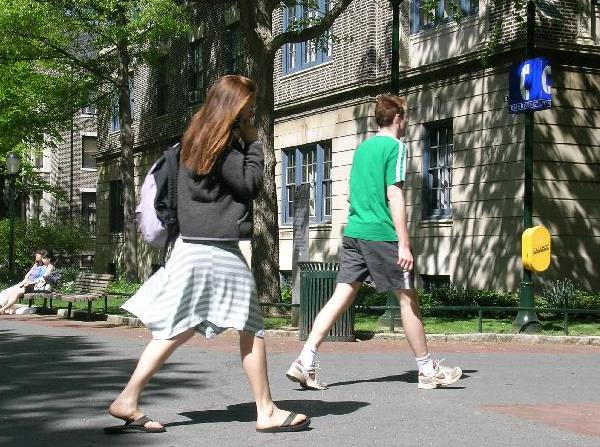

In [ ]:
from PIL import Image
mask = Image.open('PennFudanPed/PNGImages/PennPed00092.png')
mask

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms

    #이미지와 분할 마스크 정렬
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx):  #이미지와 마스크를 읽어옴
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB") #분할마스크x, 이미지만 rgb변환

    mask = Image.open(mask_path)
    mask = np.array(mask) 
    obj_idds = np.unique(mask)
    obj_ids = obj_ids[1:] #첫번째 id는 배경->제거

    masks = mask == obj_ids[:, None, None] # ***컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눔
    #각 마스크의 바운딩 박스 좌표 얻기
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxs.append([xmin, ymin, xmax, ymax])
      
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8) 

    image_idx = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels 
    target["masks"] = masks 
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd 

    if self.transforms is not None: 
      img, target = self.transforms(img, target) 

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 